# Word2Vec Tutorial Notes & Modifications <a id=top> </a>
`MMV | 12/4 | w266 Final Project: Crosslingual Word Embeddings`   


The code in this notebook follows [this tutorial](http://adventuresinmachinelearning.com/word2vec-tutorial-tensorflow/)  which is based on the [TensorFlow tutorial code](https://github.com/tensorflow/tensorflow/blob/r1.2/tensorflow/examples/tutorials/word2vec/word2vec_basic.py). I will first attempt to the basic Word2Vec algorithm to a sample of our data (Wikipedia dumps in English). Then I'll examine different ways of visualizing the embeddings that result. Finally I will explore what it might look like to make [Duong et al's modifications](https://arxiv.org/pdf/1606.09403.pdf) to train crosslingual embeddings.

# Embeddings Overview 

__Basic Idea__: start with 1-hot vector, pass it through a linear activation layer then into a softmax and optimize for the probability of nearby words(Skipgram) or the centerword(CBOW). The 'embeddings' are the parameters of the linear activation (which transform the vector of size $|V|$ into an embedding of size $N$:
$$\text{Weight Matrix:}\qquad W \in \mathbb{R}^{|V|\times N}$$
$$\text{Bias (?):}\qquad b \in \mathbb{R}^{n}$$

__Key Modifications:__ 
* Duong et all use a CBOW style algorithm but substitute a word's translation at training time so that they learn embeddings for the target language word based on the source language context. (see section 4.1)
* As a result, instead of a single weight matrix, they use a concatenation of two (see section 4 intro):
$$\text{Context Matrix:}\qquad W \in \mathbb{R}^{|V|\times N}$$
$$\text{Embedding Matrix:}\qquad U \in \mathbb{R}^{|V|\times N}$$
* Since normalizing Softmax is costly, they instead optimize for a _log-pseudo likelihood_ by learning to differentiate data from negative examples selected from a noise distribution (following Mikolov 2013, see section 3) (Note that the TF tutorial models how to do this 'noise contrastive estimation').

# Notebook Setup

In [84]:
# general imports
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys  
import math
import random
import sklearn
import numpy as np
import collections
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

# set decoding for matplotlib to handle accents
# also avoiding https://stackoverflow.com/questions/25494182/print-not-showing-in-ipython-notebook-python
stdout = sys.stdout
#reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

# tell matplotlib not to open a new window
%matplotlib inline

In [2]:
# filepaths
BASE = '/home/mmillervedam/Data'
FPATH_EN = BASE + '/test/wiki_en_10K.txt' # first 10000 lines from wiki dump
FPATH_ES = BASE + '/test/wiki_es_10K.txt' # first 10000 lines from wiki dump
FULL_EN = BASE + '/en/full.txt'
FULL_ES = BASE + '/es/full.txt'
DPATH = '/home/mmillervedam/ProjectRepo/XlingualEmb/data/dicts/en.es.panlex.all.processed'

In [3]:
# globals
VOCAB_SIZE = 5000

# Data Load & Tokenize

In [4]:
# Helper function
def read_data(filename):
    """
    Extract the file as a list of words.
    NOTE: this is modified from original function in TF  
    tutorialwhich expected a zipped input file.
    """
    with open(filename) as f:
        data = tf.compat.as_str(f.read()).split()
    return data

In [86]:
# Tokenizer preserves order (see code in Appendix)
en_raw = read_data(FPATH_EN)
es_raw = read_data(FPATH_ES)

In [88]:
# take a look
print(en_raw[:10])
print(es_raw[:10])

__`NOTE!`__ We'll need to prepend 'en' and 'es' before training crosslingual versions.   
__`QUESTIONS:`__ Do we deal with special characters?, punctuation?

# Build Vocabulary

In [5]:
# Helper function
def build_dataset(words, n_words):
    """
    Process raw inputs into a dataset.
    Creates vocabulary from top n words indexed by rank.
    NOTE: this function is directly from TF tutorial
    """
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

In [74]:
# Dataset Builder indexes by count (see code in Appendix)
en_data, en_counts, en_dict, en_index = build_dataset(en_raw, VOCAB_SIZE)
es_data, es_counts, es_dict, es_index = build_dataset(es_raw, VOCAB_SIZE)

In [82]:
#del en_raw  # Uncomment to reduce memory.
print("ENGLISH:")
print('Most common words (+UNK):\n', en_counts[:5])
print('Sample data:\n',' '.join(['%s(%s)'%(en_index[i],i) for i in en_data[:10]]))

In [83]:
# del es_raw  # Uncomment to reduce memory.
print("SPANISH:")
print('Most common words (+UNK)\n', es_counts[:5])
print('Sample data\n:',' '.join(['%s(%s)'%(es_index[i],i) for i in es_data[:10]]))

# Generate Batched Data

In [11]:
#################### PARAMETERS ####################
batch_size = 8 # Number of inputs to process at once.
num_skips = 2 # How many times to reuse an input to generate a context.
skip_window = 2 # How many words to consider left and right.
data_index = 0  # -see note below-

In [17]:
# Helper Function
def generate_batch(data, batch_size, num_skips, skip_window):
    """
    Function to generate a training batch for the skip-gram model.
    NOTE: this wass modified from original function in TF  
    tutorial by adventuresinML tutorial - mostly just renamed.
    """
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    context = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window input_word skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # input word at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]  # this is the input word
            context[i * num_skips + j, 0] = buffer[target]  # these are the context words
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, context

__`NOTE:`__ The TF tutorial sets data_index as global inside the generate_batch function. Double check you're getting the expected behavior below b/c we're doubling up on languages. 
> `UPDATE`: OK - it looks like this is because the 'generate batch' function is used dynamically to window over the data. I'll figure out how to handle the global indexer when I get to the tensorflow portion of the code.

In [13]:
############## ENGLISH BATCHES & CONTEXT #################
# batch = list of text segmetns represented by their indices
# contexts = corresponding skip_gram context set indices
en_batch, en_context = generate_batch(en_data, batch_size, 
                                      num_skips, skip_window)

In [14]:
# take a look
print('RAW BATCH:', en_batch)
print('RAW CONTEXT:', en_context.squeeze())
print("Decoded:")
for i in range(8):
    print("   ", en_batch[i], en_index[en_batch[i]],
        '->', en_context[i, 0], en_index[en_context[i, 0]])

RAW BATCH: [  9   9  92  92 571 571  11  11]
RAW CONTEXT: [ 92   0 571  11   9  92 571   8]
Decoded:
    9 is -> 92 often
    9 is -> 0 UNK
    92 often -> 571 defined
    92 often -> 11 as
    571 defined -> 9 is
    571 defined -> 92 often
    11 as -> 571 defined
    11 as -> 8 a


In [15]:
############## SPANISH BATCHES & CONTEXT #################
# batch = list of text segmetns represented by their indices
# contexts = corresponding skip_gram context set indices
es_batch, es_context = generate_batch(es_data, batch_size, 
                                      num_skips, skip_window)

In [16]:
# take a look
print('RAW BATCH:', es_batch)
print('RAW CONTEXT:', es_context.squeeze())
print("Decoded:")
for i in range(8):
    print("   ", es_batch[i], es_index[en_batch[i]],
        '->', es_context[i, 0], es_index[es_context[i, 0]])

RAW BATCH: [   6    6 1381 1381   32   32    0    0]
RAW CONTEXT: [1381   32    0    6 1381    0    0 1381]
Decoded:
    6 los -> 1381 catalán
    6 los -> 32 :
    1381 durante -> 0 UNK
    1381 durante -> 6 en
    32 material -> 1381 catalán
    32 material -> 0 UNK
    0 a -> 0 UNK
    0 a -> 1381 catalán


__`NOTE:`__ To implment Duong et Al's work we'd perform the word substitution at this stage, replacing the words in the batch with the index of their translation... In fact we'd probably do so using a dictionary of indices for the vocab. 

# TensorFlow Model w/ full softmax (slow!)

__Step 1:__ Set up the model graph.

In [17]:
# recall that we set the vocabulary size at the top of the NB
print(VOCAB_SIZE)

5000


In [18]:
#################### PARAMETERS ####################
batch_size = 128 # Number of inputs to process at once.
embedding_size = 128 # Hidden layer representation size
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a context.

In [19]:
# initialize the TF graph
graph = tf.Graph()

In [20]:
##################### DATA PLACEHOLDERS ####################
with graph.as_default():
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_context = tf.placeholder(tf.int32, shape=[batch_size, 1])
    train_one_hot = tf.one_hot(train_context, VOCAB_SIZE)

In [21]:
#################### INPUT(EMBEDDING)LAYER #################
with graph.as_default():
    embeddings = tf.Variable(tf.random_uniform([VOCAB_SIZE, 
                                                embedding_size],
                                               -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [21]:
######################## HIDDEN LAYER ######################
with graph.as_default():
    weights = tf.Variable(tf.truncated_normal([VOCAB_SIZE, embedding_size],
                              stddev=1.0 / math.sqrt(embedding_size)))
    biases = tf.Variable(tf.zeros([VOCAB_SIZE]))
    hidden_out = tf.matmul(embed, tf.transpose(weights)) + biases

__`NOTE:`__ If we're going to se up experiments/comparisons between different embedding training methods (eg. Duongs word2vec modification vs the post training aligned word vectors referenced in the Babylon Repo)... we'll want to fix the embedding size across the multiple models. Maybe even fix the initialization for the weights?-- no in this case the weights are irrelevant across models b/c they'll be optimizing different things. Presumably part of what we're interested in is comparisons of speed to train in concert w/ efficacy on the translation task and random initialization always begs the question of 'did we just get lucky'.

In [22]:
########################## TRAIN OP ########################
with graph.as_default():
    cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=hidden_out, 
                                                labels=train_one_hot))
    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(cross_entropy)

__Step 2:__ Set up validation set - arandomly chosen set of words to use to track our progress as we train. By construction we'll pick words from the 100 most frequent in the vocabulary then use cosine similarity to find the nearest neighbors in the embedding matrix.

In [23]:
###################### VALIDATION EXAMPLES #################
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

with graph.as_default():
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [24]:
##################### SIMILARITY CALCULATION ################
with graph.as_default():
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [25]:
# Variable initializer
with graph.as_default():
    init = tf.global_variables_initializer()

__Step 3:__ Run the model & track progress by examining the matches for words in our validation set.

In [34]:
from helperfunc import generate_batch
data_index = 0 # used to track batches

def run(graph, num_steps):
    """Runner code for word2vec TF model w/ full softmax"""
    with tf.Session(graph=graph) as session:
      # We must initialize all variables before we use them.
        init.run()
        print('Initialized')

        average_loss = 0
        for step in range(num_steps):
            batch_inputs, batch_context = generate_batch(en_data,
                                                         batch_size, 
                                                         num_skips, 
                                                         skip_window)
            feed_dict = {train_inputs: batch_inputs, 
                         train_context: batch_context}

            # We perform one update step by evaluating the optimizer op 
            _, loss_val = session.run([optimizer, cross_entropy], 
                                      feed_dict=feed_dict)
            average_loss += loss_val

            if step % 100 == 0:
                if step > 0:
                    average_loss /= 100
                # The average loss is an estimate of the loss over the last 2000 batches.
                print('Average loss at step ', step, ': ', average_loss)
                average_loss = 0

            # Note that this is expensive (~20% slowdown if computed every 500 steps)
            if step % 500 == 0:
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = en_index[valid_examples[i]]
                    top_k = 8  # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                    log_str = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = en_index[nearest[k]]
                        log_str = '%s %s,' % (log_str, close_word)
                    print(log_str)

Runner Call

In [ ]:
num_steps = 10001
softmax_start_time = dt.datetime.now()
run(graph, num_steps=num_steps)
softmax_end_time = dt.datetime.now()
print("Softmax method took {} seconds to run 10000 iterations".format((softmax_end_time-softmax_start_time).total_seconds()))

In [41]:
# NOTE: output from ^^ saved to:
path = 'wtv_output/en_smalldata_10Kiter_fullsfmx.txt'
!tail -n 1 {path}

Softmax method took 1461.520475 seconds to run 10000 iterations

In [45]:
# take a look at loss
!grep 'Average' {path} | tail

Average loss at step  9100 :  5.23669617653
Average loss at step  9200 :  5.23754267216
Average loss at step  9300 :  5.30736485481
Average loss at step  9400 :  5.27600327492
Average loss at step  9500 :  5.2527682209
Average loss at step  9600 :  5.25820608616
Average loss at step  9700 :  5.34852351189
Average loss at step  9800 :  5.43696550369
Average loss at step  9900 :  5.37404325485
Average loss at step  10000 :  5.33349477768


In [59]:
# take a look at NN for 'the'
!grep 'Nearest to them:' {path} |tail

Nearest to them: chose, origin, lines, Delos, lighter, young, Nixon, remove,
Nearest to them: chose, origin, lines, Delos, lighter, young, remove, Nixon,
Nearest to them: chose, origin, lines, Delos, lighter, young, Nixon, shadow,
Nearest to them: chose, origin, lines, Delos, lighter, young, shadow, remove,
Nearest to them: chose, origin, lines, Delos, lighter, young, shadow, remove,
Nearest to them: chose, origin, lines, Delos, lighter, young, Alexander, shadow,
Nearest to them: chose, lines, origin, Delos, lighter, young, Alexander, shadow,
Nearest to them: chose, origin, lines, Delos, lighter, young, Alexander, shadow,
Nearest to them: chose, origin, lines, Delos, lighter, young, Alexander, shadow,
Nearest to them: chose, origin, lines, Delos, lighter, young, Alexander, shadow,


__`NOTE:`__ The data ^^ are undoubtedly too small... 'Alabama' shouldn't appear in the top 100 words. However I'll wait to look at larger data with the sampling method which is much more efficient.

# TensorFlow Model w/ NCE (faster)

We'll write it as a class this time for ease of calling later.

In [6]:
# Helper function
def with_self_graph(function):
    """Decorator-foo borrowed from w266 a4."""
    def wrapper(self, *args, **kwargs):
        with self.graph.as_default():
            return function(self, *args, **kwargs)
    return wrapper

In [20]:
from sklearn.manifold import TSNE

class Word2Vec(object):
    """Single Layer Neural Net to Learn Word Embeddings."""
    # This code was adapted from:
    # SOURCE: https://github.com/tensorflow/tensorflow
    #         /blob/r1.2/tensorflow/examples/tutorials
    #         /word2vec/word2vec_basic.py
    
    def __init__(self, graph=None, *args, **kwargs):
        """
        Initialize TensorFlow Neural Net Model.
        Args:
          V: vocabulary size
          H: embedding size
          
        Kwargs:
          softmax_ns = 64  (number of negative samples)
          alpha = 1.0  (learning rate)
          examples = np.array of 5 top 100 words for validation
        """
        # Set TensorFlow graph. All TF code will work on this graph.
        self.graph = graph or tf.Graph()
        self.SetParams(*args, **kwargs)
        
    @with_self_graph # TODO : remove this unless we plan to init as tf.const
    def SetParams(self, V, H, softmax_ns=64, learning_rate=1.0):
        # Model structure.
        self.V = V
        self.H = H
        
        # Training hyperparameters
        self.softmax_ns = softmax_ns
        self.alpha = 1.0
        
        # Words for validation
        self.examples = np.random.choice(100, 10, replace=False)
        
        # Results
        self.epochs_trained = 0
        self.final_embeddings = None
            
    @with_self_graph
    def BuildCoreGraph(self):
        
        batch_size = 128 # TODO : I've hard coded this for now b/c I want to get
                         # the rest of the code running, but eventually this should
                         # be inferred dynamically from the input shape as in a4.
        
        # Data Placeholders
        self.inputs_ = tf.placeholder(tf.int32, shape=[batch_size])
        self.context_ = tf.placeholder(tf.int32, shape=[batch_size, 1])
        
        # Embedding Layer
        with tf.variable_scope("Embedding_Layer"):
            self.embeddings_ = tf.Variable(tf.random_uniform([self.V, self.H], 
                                                             -1.0, 1.0), name = 'Embeddings')
            self.embed_ = tf.nn.embedding_lookup(self.embeddings_, self.inputs_)
            # Normalized Embeddings facillitate cosine similarity calculation
            # .... but don't train on these! they're just for evaluation!
            self.norm_ = tf.sqrt(tf.reduce_sum(tf.square(self.embeddings_), 1, keep_dims=True))
            self.normalized_embeddings_ = self.embeddings_ / self.norm_
            
        # Hidden Layer
        with tf.variable_scope("Hidden_Layer"):
            self.W_ = tf.Variable(tf.truncated_normal([self.V, self.H],
                                  stddev=1.0 / math.sqrt(self.H)), name = 'W')
            self.b_ = tf.Variable(tf.zeros([self.V,], dtype=tf.float32), name = 'b')
            self.logits_ = tf.matmul(self.embed_, tf.transpose(self.W_)) + self.b_
           
    @with_self_graph
    def BuildTrainingGraph(self):
        with tf.variable_scope("Training"):
            nce_args = dict(weights=self.W_, 
                            biases=self.b_, 
                            labels=self.context_, 
                            inputs=self.embed_, 
                            num_sampled=self.softmax_ns, 
                            num_classes=self.V)
            self.nce_loss_ = tf.reduce_mean(tf.nn.nce_loss(**nce_args))
            self.optimizer_ = tf.train.GradientDescentOptimizer(self.alpha)
            self.train_step_ = self.optimizer_.minimize(self.nce_loss_)
            
        
    @with_self_graph
    def BuildValidationGraph(self):
        self.test_ = tf.constant(self.examples, dtype=tf.int32)
        self.test_embed_ = tf.nn.embedding_lookup(self.normalized_embeddings_, 
                                                  self.test_)
        self.similarity = tf.matmul(self.test_embed_, 
                                    self.normalized_embeddings_, 
                                    transpose_b=True)
        
    def learn_embeddings(self, num_steps, batch_fxn, data, index, verbose = True):
        """
        Runs a specified number of training steps.
        NOTE: right now the batch fxn is hard coded with inputs: 
                  (data,batch_size=128,num_skips=2,skip_window=2)
              It should output two arrays representing the input & 
              context indices for a single batch. 
              TODO: replace this with something less clunky!
        """
        
        with tf.Session(graph=self.graph) as session:
            
            # initialize all variables
            init = tf.global_variables_initializer()
            init.run()
            print('... Model Initialized')
            if verbose:
                for var in tf.trainable_variables():
                    print("\t", var)
        
            # iterate through specificied number of training steps
            average_loss = 0
            for step in range(num_steps):
                # Get the next batch of inputs & their skipgram context
                batch_inputs, batch_context = batch_fxn(data, 128, 2, 2)

                # Run the train op
                feed_dict = {self.inputs_: batch_inputs, self.context_: batch_context}
                _, loss_val = session.run([self.train_step_, self.nce_loss_], 
                                          feed_dict=feed_dict)
                
                # Logging Progress
                average_loss += loss_val
                loss_logging_interval = num_steps // 10
                sim_logging_interval = num_steps // 5
                if not verbose:
                    continue
                if step % loss_logging_interval == 0:
                    if step > 0:
                        average_loss /= loss_logging_interval
                    # The average loss is an estimate of the loss over the last 1000 batches.
                    print('Average loss at step ', step, ': ', average_loss)
                    average_loss = 0  
                if step % sim_logging_interval == 0:
                    sim = self.similarity.eval()
                    for i in xrange(len(self.examples)):
                        word = index[self.examples[i]]
                        top_k = 8  # number of nearest neighbors
                        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                        log_str = '   Nearest to %s:' % word
                        for k in xrange(top_k):
                            nbr = index[nearest[k]]
                            log_str = '%s %s,' % (log_str, nbr)
                        print(log_str)
            # results
            self.epochs_trained = num_steps
            self.final_embeddings = self.normalized_embeddings_.eval()
        return self.final_embeddings
    
    def plot_embeddings_in_2D(self, num, index):
        """ 
        Plot 2D representation of embeddings.
        Args: 
            num = int (number of examples to plot)
            index = reverse dictionary of word indices
            filename = path to save plot
        """
        if self.final_embeddings is None:
            print("You must train the embeddings before plotting.")
        else:
            tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
            low_dim_embs = tsne.fit_transform(self.final_embeddings[:num, :])
            labels = [index[i] for i in xrange(num)]
            plt.figure(figsize=(18, 18))  # in inches
            for i, label in enumerate(labels):
                x, y = low_dim_embs[i, :]
                plt.scatter(x, y)
                plt.annotate(label, xy=(x, y), xytext=(5, 2), 
                             textcoords='offset points', ha='right', va='bottom')
            plt.show()

__Step 0:__ Data prep (_we did this above, just running a few checks here_)

In [49]:
# We'll be using the shortened version of the English Wikipedia File
print('Corpus Size: %s Words' % (len(en_data)))
print('Vocabulary Size: %s Words' % (len(en_counts)))

NameError: name 'en_data' is not defined

In [25]:
# Additional Parameters for batch function
BATCH_SIZE = 128 # Number of inputs to process at once.
EMBEDDING_SIZE = 128 # Hidden layer representation size

In [26]:
# NOTE: the following are hard coded into the class above, just here for reference 
# TODO make a better batch iterator & a data handler so we don't have to do this!
skip_window = 2 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a context.
data_index = 0 # Used to track batches for now, TODO fix batch iterator!

__Step 1:__ Create Model & Initialize TF Graph

In [27]:
model = Word2Vec(V=VOCAB_SIZE, H=EMBEDDING_SIZE)
model.BuildCoreGraph()
model.BuildTrainingGraph()
model.BuildValidationGraph()

> __`Question for Mona & Roseanna:`__ When does it makes sense to keep these graph building methods separate and when should they all be part of the same class method? In this case we're never going to run 'inference' except in the context of the test/validation exercise... because we don't really care about the ultimate prediction of context words we really care about the embeddings. I've left these as 3 methods for now (following the lead of A4) but I wonder if we could combine two or all of them when we create our Xlingual version of this class.

__Step 2:__ Train the model.

In [43]:
NSTEPS = 100000
start_time = dt.datetime.now()
embeddings = model.learn_embeddings(NSTEPS, generate_batch, en_data, en_index)
end_time = dt.datetime.now()
total = (end_time - start_time).total_seconds()
print("NCE method took {} seconds to run {} iterations".format(total, NSTEPS))

... Model Initialized
	 <tf.Variable 'Embedding_Layer/Embeddings:0' shape=(5000, 128) dtype=float32_ref>
	 <tf.Variable 'Hidden_Layer/W:0' shape=(5000, 128) dtype=float32_ref>
	 <tf.Variable 'Hidden_Layer/b:0' shape=(5000,) dtype=float32_ref>
Average loss at step  0 :  206.749420166
   Nearest to 's: north, religious, created, pest, sentiment, income, Song, vast,
   Nearest to -: \, 1830s, 300, defeated, writings, sought, abugida, pH,
   Nearest to many: category, popularity, high, pressure, unit-treatment, Communist, phenomenon, 1983,
   Nearest to have: Danneskjöld, displayed, older, colonization, acquire, encouraging, brain, census,
   Nearest to one: doctrine, fit, Aristotelian, poison, combination, respiration, territory, ground,
Average loss at step  10000 :  8.47071304774
Average loss at step  20000 :  4.62633442709
   Nearest to 's: technologies, created, appeals, religious, troops, Moscow, chemicals, pest,
   Nearest to -: \, sought, 1830s, defeated, 300, oviduct, abugida, wri

__`Note:`__ This code ^ is logging the sampled softmax loss... (NCE)... not sure if thats terribly instructive.

Plot the resulting embeddings.

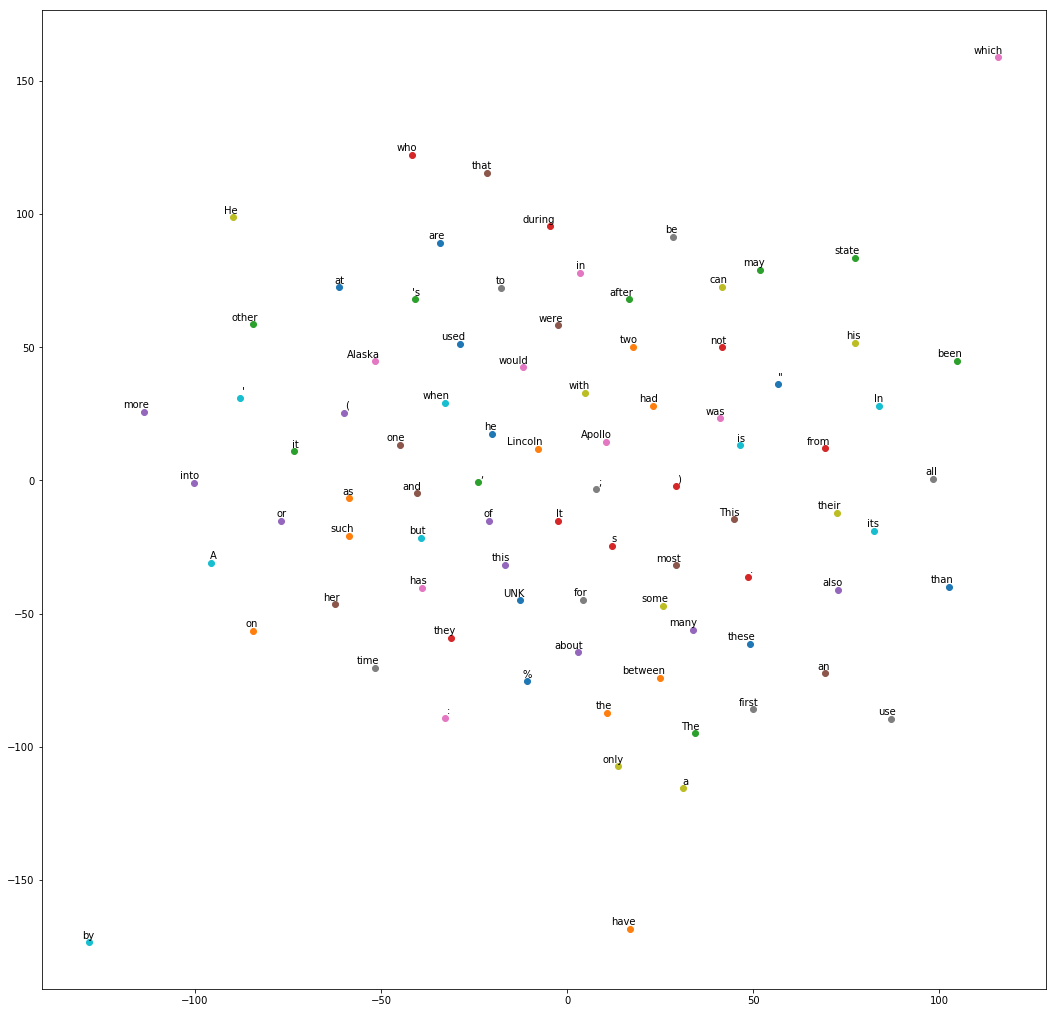

In [49]:
model.plot_embeddings_in_2D(100, en_index)

__`NOTE:`__ This plotting code clearly needs some work... but cool idea. Note that matplotlib is going to throw a fit when it encounters non ascii characters which will present a challenge in other languages. I think it makes sense to rewrite the method so that it accepts a specific set of input words or indices not just a number of top words to plot.

# Word2Vec on Full Spanish Data Set

__Step 0:__ Data Prep

In [21]:
VOCAB_SIZE = 10000
BATCH_SIZE = 128 # Number of inputs to process at once.
EMBEDDING_SIZE = 128 # Hidden layer representation size
data_index = 0 # Used to track batches for now, TODO fix batch iterator!

In [22]:
# read in raw file
es_raw = read_data(FULL_ES)

In [23]:
# parse data into dictionary
es_data, es_counts, es_es_dict, es_index = build_dataset(es_raw, VOCAB_SIZE)

In [24]:
# take a look
del es_raw  # reduce memory.
print('Corpus Size: %s Words' % (len(es_data)))
print('Vocabulary Size: %s Words' % (len(es_counts)))
print('Most common words (+UNK)\n', es_counts[:5])
print('Sample data\n:',' '.join(['%s(%s)'%(es_index[i],i) for i in es_data[:10]]))

Corpus Size: 397166866 Words
Vocabulary Size: 10000 Words
Most common words (+UNK)
 [['UNK', 59528082], ('de', 26901947), (',', 19169040), ('.', 13014656), ('la', 12852779)]
Sample data
: UNK(0) El(24) Principado(7192) de(1) UNK(0) ((18) en(5) catalán(3102) :(31) UNK(0)


__Step 1:__ Initialize Model

In [25]:
model = Word2Vec(V=VOCAB_SIZE, H=EMBEDDING_SIZE)
model.BuildCoreGraph()
model.BuildTrainingGraph()
model.BuildValidationGraph()

__Step 2:__ Train Model.

In [26]:
NSTEPS = 100001
start_time = dt.datetime.now()
embeddings = model.learn_embeddings(NSTEPS, generate_batch, es_data, es_index)
end_time = dt.datetime.now()
total = (end_time - start_time).total_seconds()
print("NCE method took {} seconds to run {} iterations".format(total, NSTEPS))

... Model Initialized
	 <tf.Variable 'Embedding_Layer/Embeddings:0' shape=(10000, 128) dtype=float32_ref>
	 <tf.Variable 'Hidden_Layer/W:0' shape=(10000, 128) dtype=float32_ref>
	 <tf.Variable 'Hidden_Layer/b:0' shape=(10000,) dtype=float32_ref>
Average loss at step  0 :  238.714202881
   Nearest to fueron: Castilla, enlaces, Goya, delitos, Mediterráneo, occidental, movimientos, sede,
   Nearest to años: Unión, confirmó, St, Racing, curso, datan, Taxonomía, causar,
   Nearest to externos: afirmar, cromosoma, perros, actuó, Antonio, aplicación, incursiones, antepasados,
   Nearest to encuentra: Road, horas, prisión, Baviera, Civil, Polo, estaría, Cádiz,
   Nearest to con: registros, Pereira, playas, internacional, incursiones, reptiles, Los, acompañados,
   Nearest to que: sexo, dragón, militar, Ricardo, Tipos, Dan, cuántica, Latinoamérica,
   Nearest to familia: pistola, artistas, 1935, nazi, guerra, Max, ha, ligada,
   Nearest to las: Imagen, aparecido, rodeada, África, utiliza, extra

__Step 3:__ Plot a few of the embeddings.

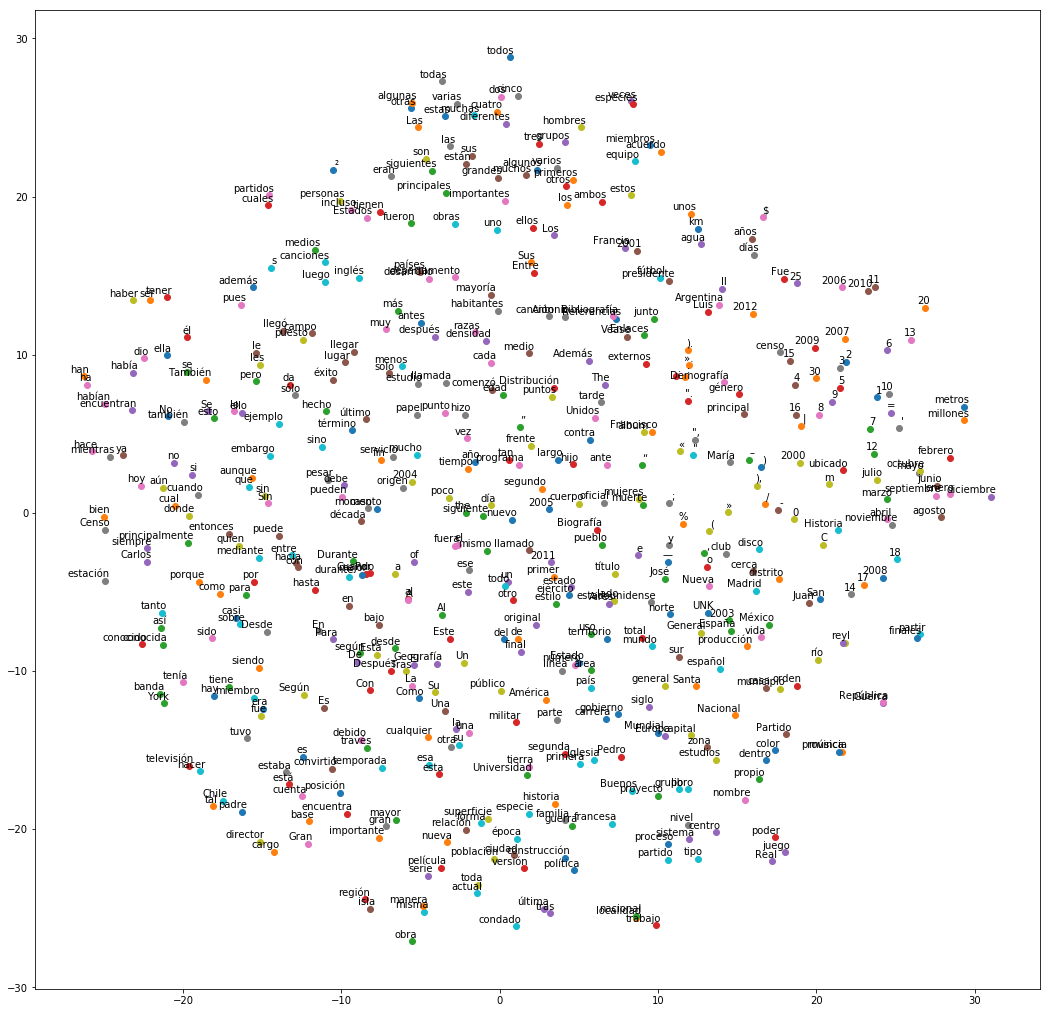

In [48]:
model.plot_embeddings_in_2D(500, es_index)

__Step 4:__ Save embeddings & index

In [90]:
# confirm dim
model.final_embeddings.shape

(10000, 128)

In [93]:
# dictionary
len(es_index)

10000

In [94]:
# make them a tuple to pickle
embeddings_tuple = (es_index, model.final_embeddings)

In [101]:
# save to file
import pickle
filename = './wtv_output/es_w2v_100K_embed.pkl'
with open(filename, 'wb') as f:
    pickle.dump(embeddings_tuple, f)

In [102]:
# confirm reload
filename = './wtv_output/es_w2v_100K_embed.pkl'
with open(filename, 'rb') as f:
    test_tuple = pickle.load(f)

In [110]:
test_tuple[1][:10]

array([[ 0.03819602, -0.13329849, -0.01429227, ..., -0.03769526,
         0.05235088, -0.02932183],
       [ 0.12865098, -0.01456919, -0.03162299, ..., -0.03951048,
         0.05114633, -0.04463609],
       [ 0.14282851,  0.00256916, -0.07392539, ..., -0.07552823,
        -0.00961217, -0.06581203],
       ..., 
       [ 0.12065734, -0.05934527, -0.01479576, ..., -0.08494201,
        -0.07381459,  0.05828848],
       [-0.04433526, -0.03974896,  0.05540834, ..., -0.00425081,
         0.00412568, -0.0206273 ],
       [ 0.07668579, -0.10201769, -0.00611493, ..., -0.0942871 ,
         0.04488795,  0.11033946]], dtype=float32)